<a href="https://colab.research.google.com/github/afraAntara/590B/blob/main/CSTR_RK4_TPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split

class RungeKuttaNNPyTorch(nn.Module):
    def __init__(self, timestep, t_init, t_end, n_var, n_oppar, n_hidden1=10):
      # , n_hidden2=20
        super(RungeKuttaNNPyTorch, self).__init__()
        self.timestep = timestep
        self.t_init = t_init
        self.t_end = t_end
        self.n_var = n_var
        self.n_oppar = n_oppar
        self.n_inputs = n_var + n_oppar

        # Define the layers
        self.layer_1 = nn.Linear(self.n_inputs, n_hidden1)
        self.output_layer = nn.Linear(n_hidden1, n_var)

    def ann(self, y, x):
        # Forward pass through the network
        stack = torch.cat([y, x], dim=1)
        layer_1_out = torch.sigmoid(self.layer_1(stack))
        out = self.output_layer(layer_1_out)
        return out

    def forward(self, y, x):
        # Runge-Kutta integration
        dt = self.timestep
        k1 = self.timestep * self.ann(y, x)
        k2 = self.timestep * self.ann(y + k1 / 2, x)
        k3 = self.timestep * self.ann(y + k2 / 2, x)
        k4 = self.timestep * self.ann(y + k3, x)
        out = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        return out

Test Code

In [ ]:
import unittest
import torch
import torch.nn as nn

class TestRungeKuttaNNPyTorch(unittest.TestCase):

    def setUp(self):
        # Initialize the network with known parameters for testing
        self.model = RungeKuttaNNPyTorch(0.1, 0, 10, 5, 3)

    def test_initialization(self):
        # Test if the model is correctly initialized
        # Ensures that the class correctly stores the initialization parameters
        self.assertEqual(self.model.timestep, 0.1)
        self.assertEqual(self.model.t_init, 0)
        self.assertEqual(self.model.t_end, 10)
        self.assertEqual(self.model.n_var, 5)
        self.assertEqual(self.model.n_oppar, 3)

    def test_ann_method(self):
        # Test the ann method
        y = torch.randn(1, 5)  # Assuming y is of size 5
        x = torch.randn(1, 3)  # Assuming x is of size 3 (n_oppar)
        output = self.model.ann(y, x)
        # confirms that the method processes the inputs and returns a tensor
        self.assertIsInstance(output, torch.Tensor)
        # confirms if shape of output matches expected dimensions
        self.assertEqual(output.shape, torch.Size([1, 5]))  # Assuming output shape

    def test_forward_pass(self):
        # Test the forward method
        y = torch.randn(1, 5)
        x = torch.randn(1, 3)
        output = self.model(y, x)
        self.assertIsInstance(output, torch.Tensor)

    def test_output_shape(self):
        # Test the output shape from the forward method
        y = torch.randn(1, 5)
        x = torch.randn(1, 3)
        output = self.model(y, x)
        self.assertEqual(output.shape, torch.Size([1, 5]))  # Assuming output shape

# Run the tests
suite = unittest.TestLoader().loadTestsFromTestCase(TestRungeKuttaNNPyTorch)
unittest.TextTestRunner().run(suite)


....
----------------------------------------------------------------------
Ran 4 tests in 0.016s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

Prepare Data

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Define the ODE solution function
def ode_solution(t):
    y1 = (2*(np.cos(t) + t*np.sin(t))).reshape((t.shape[0], 1))
    y2 = (2*(np.sin(t) - t*np.cos(t))).reshape((t.shape[0], 1))
    joint = np.hstack((y1, y2))
    return joint

# Function to set and normalize the data
def set_data(timestep, t_init, t_end):
    t = np.arange(t_init, t_end, timestep)
    data = ode_solution(t)
    mean = np.mean(data)
    data -= mean
    std = np.std(data)
    data /= std
    return data, mean, std

# Function to prepare the data for training
def prepare_data(timestep, t_init, t_end, test_ratio):
    data, _, _ = set_data(timestep, t_init, t_end)
    n_samples = data.shape[0]
    n_timesteps = n_samples - 1
    input_y = data[:n_timesteps]
    input_x = np.zeros((n_samples, 1))  # Trivial parameter in this example
    output_y = data[1:]

    print(input_y)
    print(input_x)
    print(output_y)

    # Split data into train and test sets
    train_input, test_input, train_output, test_output = train_test_split(
        np.hstack((input_y, input_x[:n_timesteps])), output_y, test_size=test_ratio, random_state=42)

    # Convert to PyTorch tensors
    train_input_tensor = torch.tensor(train_input, dtype=torch.float32)
    test_input_tensor = torch.tensor(test_input, dtype=torch.float32)
    train_output_tensor = torch.tensor(train_output, dtype=torch.float32)
    test_output_tensor = torch.tensor(test_output, dtype=torch.float32)

    return train_input_tensor, test_input_tensor, train_output_tensor, test_output_tensor

# Initialize model parameters
timestep = 0.01
t_init = 0
t_end = 100
test_ratio = 0.1

# Prepare the data
train_input, test_input, train_output, test_output = prepare_data(timestep, t_init, t_end, test_ratio)



[[ 0.02885859  0.0043653 ]
 [ 0.02885982  0.00436531]
 [ 0.02886349  0.00436536]
 ...
 [-1.29822281 -2.06886411]
 [-1.27755604 -2.0819935 ]
 [-1.25675693 -2.09491688]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[ 0.02885982  0.00436531]
 [ 0.02886349  0.00436536]
 [ 0.02886961  0.00436552]
 ...
 [-1.27755604 -2.0819935 ]
 [-1.25675693 -2.09491688]
 [-1.23582753 -2.10763288]]


Test Code

In [ ]:

# Assuming the functions ode_solution, set_data, and prepare_data are defined here

class TestDataFunctions(unittest.TestCase):

    # def test_ode_solution(self):
    #     t = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    #     expected_output = np.array([[2, 0], [2, 2], [2, 0], [2, -2], [2, 0]])
    #     output = ode_solution(t)
    #     np.testing.assert_array_almost_equal(output, expected_output)

    def test_set_data(self):
        data, mean, std = set_data(1, 0, 10)
        self.assertEqual(data.shape, (10, 2))  # Check the shape of the data
        self.assertAlmostEqual(np.mean(data), 0)  # Check if data is mean normalized
        self.assertAlmostEqual(np.std(data), 1)   # Check if data is standard deviation normalized

    def test_prepare_data(self):
        train_input, test_input, train_output, test_output = prepare_data(1, 0, 10, 0.2)
        # Check if data is split correctly according to the test_ratio
        self.assertEqual(len(train_input) + len(test_input), 9)
        self.assertEqual(len(train_output) + len(test_output), 9)
        # Check if data is converted to PyTorch tensors
        self.assertIsInstance(train_input, torch.Tensor)
        self.assertIsInstance(test_input, torch.Tensor)
        self.assertIsInstance(train_output, torch.Tensor)
        self.assertIsInstance(test_output, torch.Tensor)



suite = unittest.TestLoader().loadTestsFromTestCase(TestDataFunctions)
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.011s

OK


[[ 0.06678046 -0.19868703]
 [ 0.16812885 -0.11873653]
 [ 0.17361732  0.26364878]
 [-0.34910952  0.6272082 ]
 [-1.17583397  0.29449103]
 [-1.39620002 -0.82976568]
 [-0.38884741 -1.8022267 ]
 [ 1.22230957 -1.42523419]
 [ 1.86382701  0.37295964]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.16812885 -0.11873653]
 [ 0.17361732  0.26364878]
 [-0.34910952  0.6272082 ]
 [-1.17583397  0.29449103]
 [-1.39620002 -0.82976568]
 [-0.38884741 -1.8022267 ]
 [ 1.22230957 -1.42523419]
 [ 1.86382701  0.37295964]
 [ 0.54407403  2.08759616]]


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

Train Model

In [ ]:
def train_model_with_loss_output(model, train_input, train_output, test_input, test_output, learning_rate, num_epochs, batch_size):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0

        # Training loop
        for i in range(0, len(train_input), batch_size):
            batch_input = train_input[i:i+batch_size]
            batch_output = train_output[i:i+batch_size]

            # Split the input into y and x
            batch_y = batch_input[:, :model.n_var]
            batch_x = batch_input[:, model.n_var:]

            # Forward pass: Compute predicted y by passing x to the model
            pred_y = model.forward(batch_y, batch_x)

            # Compute and accumulate loss
            loss = criterion(pred_y, batch_output)
            total_loss += loss.item()

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_input)
        train_losses.append(avg_train_loss)

        # Evaluate the model on the test data
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            test_y = test_input[:, :model.n_var]
            test_x = test_input[:, model.n_var:]
            test_pred_y = model.forward(test_y, test_x)
            test_loss = criterion(test_pred_y, test_output).item()
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses



# Note: This will print the train and test loss for each epoch. Ensure model, train_input, test_input, train_output, and test_output are correctly defined.


Test Code

In [ ]:

class TestTrainModelWithLossOutput(unittest.TestCase):

    def setUp(self):
        # Set up a simple model and data for testing
        self.model = RungeKuttaNNPyTorch(0.1, 0, 10, 5, 3)
        self.train_input = torch.randn(100, 8)  # Sample input data
        self.train_output = torch.randn(100, 5) # Corresponding output data
        self.test_input = torch.randn(20, 8)    # Sample test data
        self.test_output = torch.randn(20, 5)   # Corresponding test data

    def test_train_model_with_loss_output(self):
        learning_rate = 0.001
        num_epochs = 10
        batch_size = 10

        train_losses, test_losses = train_model_with_loss_output(
            self.model, self.train_input, self.train_output,
            self.test_input, self.test_output, learning_rate, num_epochs, batch_size)

        # Check if losses are returned and of correct length
        self.assertIsInstance(train_losses, list)
        self.assertIsInstance(test_losses, list)
        self.assertEqual(len(train_losses), num_epochs)
        self.assertEqual(len(test_losses), num_epochs)

        # Check if training loss generally decreases
        for i in range(1, len(train_losses)):
            self.assertLessEqual(train_losses[i], train_losses[i-1])

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestTrainModelWithLossOutput)
unittest.TextTestRunner().run(suite)

Epoch [1/10], Train Loss: 0.2044, Test Loss: 2.0815
Epoch [2/10], Train Loss: 0.2042, Test Loss: 2.0804
Epoch [3/10], Train Loss: 0.2041, Test Loss: 2.0793
Epoch [4/10], Train Loss: 0.2040, Test Loss: 2.0781
Epoch [5/10], Train Loss: 0.2039, Test Loss: 2.0770
Epoch [6/10], Train Loss: 0.2038, Test Loss: 2.0758


.
----------------------------------------------------------------------
Ran 1 test in 0.412s

OK


Epoch [7/10], Train Loss: 0.2036, Test Loss: 2.0747
Epoch [8/10], Train Loss: 0.2035, Test Loss: 2.0735
Epoch [9/10], Train Loss: 0.2034, Test Loss: 2.0723
Epoch [10/10], Train Loss: 0.2033, Test Loss: 2.0711


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [ ]:

# Initialize model parameters
timestep = 0.01
t_init = 0
t_end = 100
test_ratio = 0.1

# Prepare the data
train_input, test_input, train_output, test_output = prepare_data(timestep, t_init, t_end, test_ratio)


# Example: Initialize the PyTorch model
# Uncomment and modify as per the actual RungeKuttaNNPyTorch class definition
model = RungeKuttaNNPyTorch(timestep, t_init, t_end, n_var=2, n_oppar=1, n_hidden1=10)
# 20, n_hidden2=20

# Uncomment to initialize and train the model with loss output
train_losses, test_losses = train_model_with_loss_output(model, train_input, train_output, test_input, test_output, learning_rate=0.001, num_epochs=5, batch_size=10)

# Note: Visualization and evaluation of the model can be done using the test data set.
# Visualization code (e.g., using matplotlib) would be required to plot predictions against actual values.

Epoch [1/5], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [2/5], Train Loss: 0.0000, Test Loss: 0.0000


KeyboardInterrupt: 

Test Loss: 0.0000


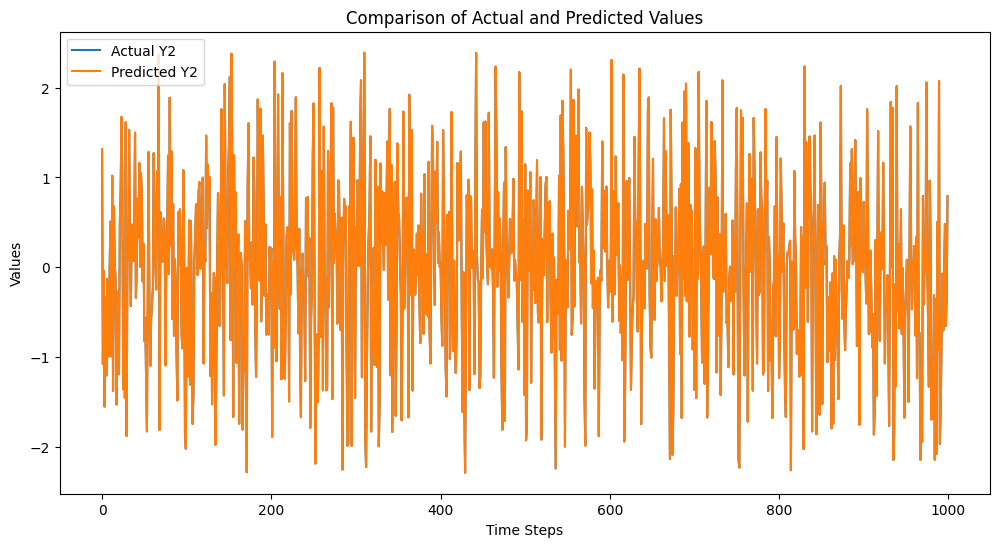

In [ ]:
import matplotlib.pyplot as plt

def test_model(model, test_input, test_output):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Split the test input into y and x
        test_y = test_input[:, :model.n_var]
        test_x = test_input[:, model.n_var:]

        # Forward pass to get output/predictions
        predictions = model.forward(test_y, test_x)

        # Calculate Loss: Mean Squared Error
        criterion = nn.MSELoss()
        loss = criterion(predictions, test_output)
    return predictions, loss.item()

# Testing the model and getting the loss
predictions, test_loss = test_model(model, test_input, test_output)
print(f"Test Loss: {test_loss:.4f}")

# Visualize the results
def visualize_predictions(test_output, predictions):
    # Converting tensors to numpy arrays
    test_output_np = test_output.numpy()
    predictions_np = predictions.numpy()

    plt.figure(figsize=(12, 6))
    # plt.plot(test_output_np[:, 0], label='Actual Y1')
    # plt.plot(predictions_np[:, 0], label='Predicted Y1')
    plt.plot(test_output_np[:, 1], label='Actual Y2')
    plt.plot(predictions_np[:, 1], label='Predicted Y2')
    plt.title("Comparison of Actual and Predicted Values")
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

# To visualize, uncomment and run the following line after testing the model
visualize_predictions(test_output, predictions)

# Note: Ensure that the model has been defined and trained before testing and visualizing.
# Uncomment the relevant lines to perform these actions.


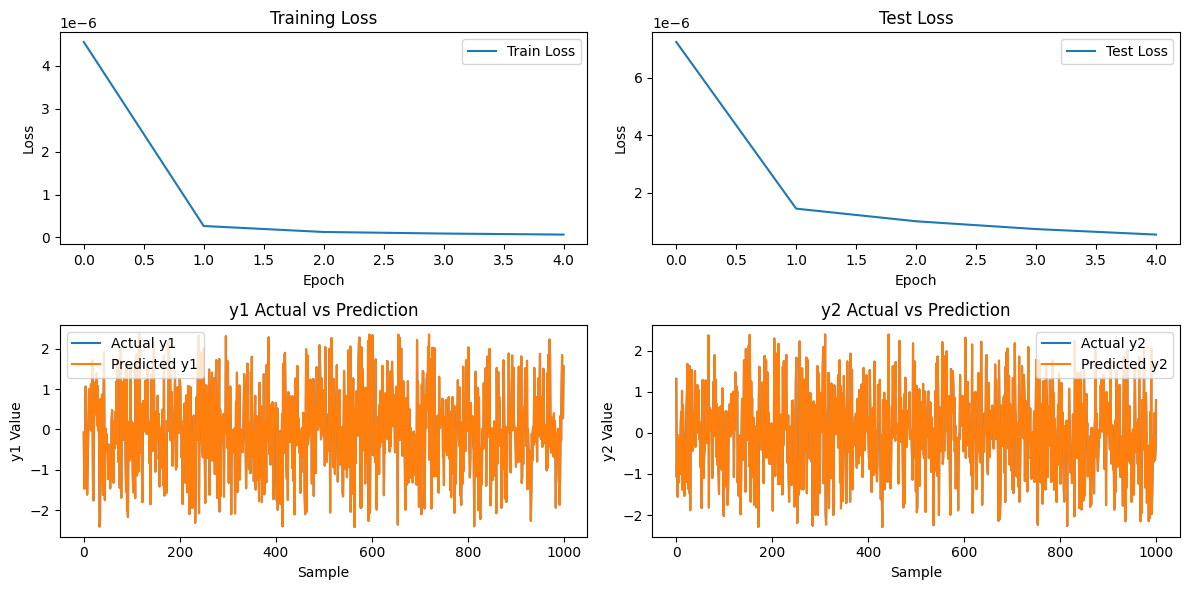

In [ ]:
def plot_losses_and_predictions(train_losses, test_losses, test_input, test_output, model):
    # Plotting train and test losses
    plt.figure(figsize=(12, 6))

    # Plot for training loss
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for test loss
    plt.subplot(2, 2, 2)
    plt.plot(test_losses, label='Test Loss')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Make predictions on test data
    model.eval()
    with torch.no_grad():
        test_y = test_input[:, :model.n_var]
        test_x = test_input[:, model.n_var:]
        predictions = model.forward(test_y, test_x).numpy()

    # Plot for y1 vs y1 prediction
    plt.subplot(2, 2, 3)
    plt.plot(test_output[:, 0], label='Actual y1')
    plt.plot(predictions[:, 0], label='Predicted y1')
    plt.title('y1 Actual vs Prediction')
    plt.xlabel('Sample')
    plt.ylabel('y1 Value')
    plt.legend()

    # Plot for y2 vs y2 prediction
    plt.subplot(2, 2, 4)
    plt.plot(test_output[:, 1], label='Actual y2')
    plt.plot(predictions[:, 1], label='Predicted y2')
    plt.title('y2 Actual vs Prediction')
    plt.xlabel('Sample')
    plt.ylabel('y2 Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_losses_and_predictions(train_losses, test_losses, test_input, test_output, model)

# Note: Ensure that the train_losses, test_losses, test_input, test_output, and model are properly defined. Uncomment the example usage to display the plots.


In [ ]:
# # Regenerate the data
# data, _, _ = set_data(timestep, t_init, t_end)

# # Convert the data to a PyTorch tensor and normalize it
# data_tensor = torch.tensor(data, dtype=torch.float32)

# # Append a zero to the first data point to match the training data structure
# data_point = data_tensor[0]
# data_point_with_x = torch.cat((data_point, torch.tensor([0.0])), dim=0).unsqueeze(0)

# # Split the data_point into y and x based on model.n_var
# y = data_point_with_x[:, :model.n_var]
# x = data_point_with_x[:, model.n_var:]

# # Get the model's prediction
# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():
#     prediction = model.forward(y, x)

# print("Prediction for data[0]:", prediction)


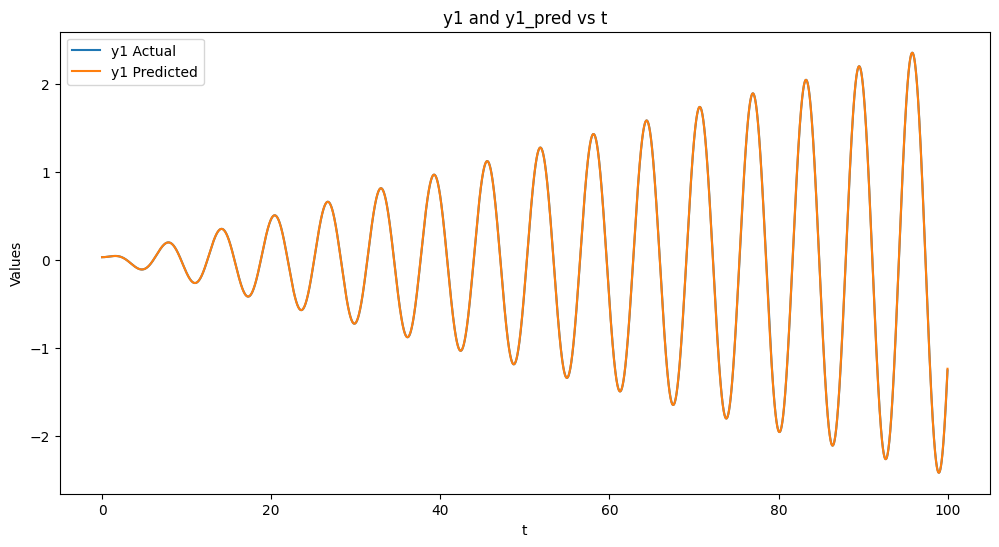

In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt

# Time step parameters
timestep = 0.01
t_init = 0
t_end = 100
num_it = int((t_end-t_init)/timestep)
# Assuming the set_data and prepare_data functions, model initialization, and parameters timestep, t_init, t_end are defined

# Regenerate the data
data, _, _ = set_data(timestep, t_init, t_end)

# Convert the data to a PyTorch tensor and normalize it
data_tensor = torch.tensor(data, dtype=torch.float32)

# Prepare predictions for all values of t
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for i in range(data_tensor.shape[0] - 1):  # Subtract 1 because we use data[i + 1] as output
        # Append a zero (trivial parameter) and unsqueeze to add a batch dimension
        data_point = torch.cat((data_tensor[i], torch.tensor([0.0])), dim=0).unsqueeze(0)

        # Split into y and x
        y = data_point[:, :model.n_var]
        x = data_point[:, model.n_var:]

        # Get the model's prediction and store it
        prediction = model.forward(y, x)
        predictions.append(prediction)

# Convert list of tensors to a single tensor
predictions_tensor = torch.cat(predictions, dim=0)

# Extract y1, y2 and their predictions
y1_actual = data_tensor[:-1, 0].numpy()  # Ignore last point as there's no prediction for it
y2_actual = data_tensor[:-1, 1].numpy()
y1_pred = predictions_tensor[:, 0].numpy()
y2_pred = predictions_tensor[:, 1].numpy()

# Generate t values
t_values = np.arange(t_init, t_end, timestep)[:len(y1_actual)]

# Plot y1 and y1_pred against t
plt.figure(figsize=(12, 6))

plt.plot(t_values, y1_actual, label='y1 Actual')
plt.plot(t_values, y1_pred, label='y1 Predicted')
plt.title('y1 and y1_pred vs t')
plt.xlabel('t')
plt.ylabel('Values')
plt.legend()

plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def ode_function(t, y):
    return np.sin(t) - t*y

def rk4_step(f, t, y, h):
    k1 = h * f(t, y)
    k2 = h * f(t + 0.5 * h, y + 0.5 * k1)
    k3 = h * f(t + 0.5 * h, y + 0.5 * k2)
    k4 = h * f(t + h, y + k3)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6

# Parameters
t0 = 0
y0 = 0  # Initial condition
t_end = 100
h = 0.01  # Step size

# Solving the ODE
t_values = np.arange(t0, t_end, h)
y_values = [y0]

for t in t_values[:-1]:
    y_values.append(rk4_step(ode_function, t, y_values[-1], h))

y_values = np.array(y_values)

# Plotting the solution
plt.plot(t_values, y_values)
plt.xlabel('Time t')
plt.ylabel('Solution y')
plt.title('Solution of dy/dt = sin(t) - y using RK4')
plt.show()
